<a href="https://colab.research.google.com/github/hwangzie/Detect-Corner-Mark-on-Device-and-Image-Quality/blob/main/Corner_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os

In [3]:
# load the dir for labeling
data_dir = '/content/drive/MyDrive/Dataset_NBS'
dataset =  tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    labels='inferred',
    label_mode='binary',
    class_names=['false', 'true'],
    batch_size=16,
    image_size=(224, 224),
    shuffle=True
)
# Data augmentation
data_augmentation = tf.keras.Sequential([
    layers.Input(shape=(224, 224, 3)),
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
])

Found 240 files belonging to 2 classes.


Labels: [[0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]
 [0.]
 [0.]
 [0.]
 [1.]
 [0.]
 [1.]
 [0.]
 [1.]
 [1.]
 [1.]]


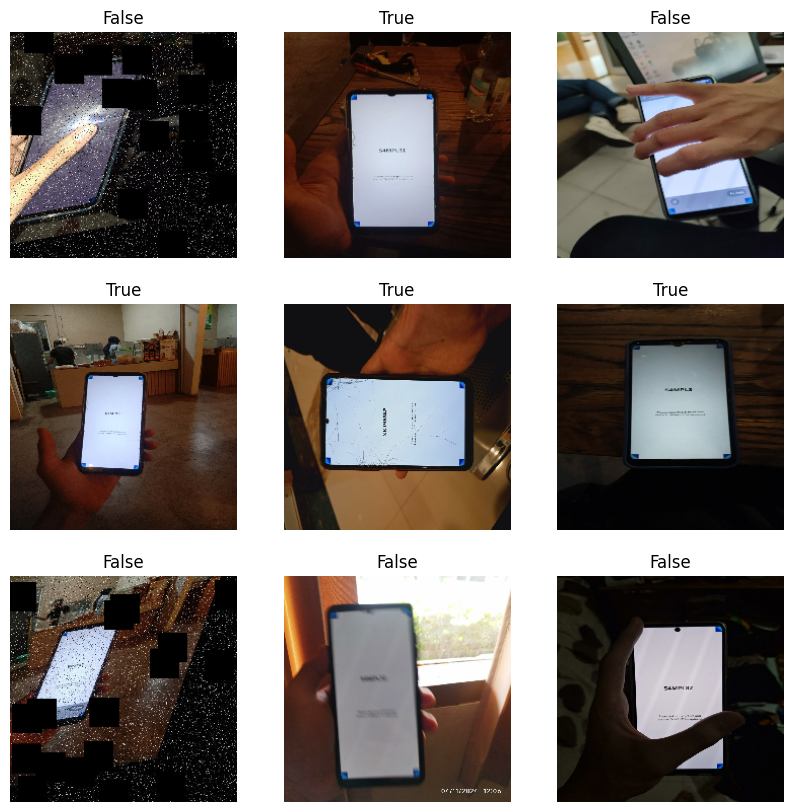

In [4]:
# Display one batch of images and labels
for images, labels in dataset.take(1):  # Take a single batch
    print("Labels:", labels.numpy())    # Print labels (0 or 1 for binary)

    # Plot the images
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Display 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # Access the probability for the 'True' class (assuming it's the first class)
        # and display 'True' if it's greater than 0.5, otherwise 'False'
        plt.title("False" if labels[i][0] < 0.5 else "True")
        plt.axis("off")
    plt.show()

In [5]:
# base_model = tf.keras.applications.MobileNetV3Small(
#     input_shape=(224, 224, 3),
#     include_top=False,
#     weights='imagenet'
# )

base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    alpha=1.0,
    include_top=False,
    weights='imagenet',
)

base_model.trainable = False
layer_index = None
# for i, layer in enumerate(base_model.layers):
#     if layer.name == 'block_6_project_BN':
#         layer_index = i
#         break
# if layer_index is not None:
#     base_model = tf.keras.Model(inputs=base_model.input, outputs=base_model.layers[layer_index].output)
#     base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [6]:
model = tf.keras.models.Sequential([
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(512, activation='relu',kernel_regularizer=tf.keras.regularizers.l2(0.1)),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [7]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# callback if model reach 89 accuracy
class myCallback(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('accuracy')>0.95):
            print("\nReached 89% accuracy so cancelling training!")
            self.model.stop_training = True

callbacks = myCallback()


In [22]:
# Import necessary libraries
from IPython.display import clear_output
import gc
import tensorflow as tf
# Clear all variables and garbage collect
gc.collect()
# Reset TensorFlow session to release memory
tf.keras.backend.clear_session()
# Clear the output in Colab
clear_output()

In [8]:
history = model.fit(dataset, epochs=30, callbacks=[callbacks])

Epoch 1/30


/usr/local/lib/python3.10/dist-packages/keras/src/backend/tensorflow/nn.py:707: UserWarning: "`binary_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Sigmoid activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


15/15 ━━━━━━━━━━━━━━━━━━━━ 26s 862ms/step - accuracy: 0.7248 - loss: 72.4418
Epoch 2/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 417ms/step - accuracy: 0.7737 - loss: 67.3310
Epoch 3/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 9s 332ms/step - accuracy: 0.8275 - loss: 62.5392
Epoch 4/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 419ms/step - accuracy: 0.8533 - loss: 58.0236
Epoch 5/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 4s 298ms/step - accuracy: 0.8663 - loss: 53.8856
Epoch 6/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 299ms/step - accuracy: 0.8714 - loss: 49.9091
Epoch 7/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 437ms/step - accuracy: 0.8738 - loss: 46.2700
Epoch 8/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 291ms/step - accuracy: 0.8528 - loss: 42.8816
Epoch 9/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 486ms/step - accuracy: 0.8876 - loss: 39.6549
Epoch 10/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 7s 288ms/step - accuracy: 0.8584 - loss: 36.7876
Epoch 11/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 6s 433ms/step - accuracy: 0.8775 - loss: 33.9737
Epoch 12/30
15/15 ━━━━━━━━━━━━━━━━━━━━ 8s 294ms/ste

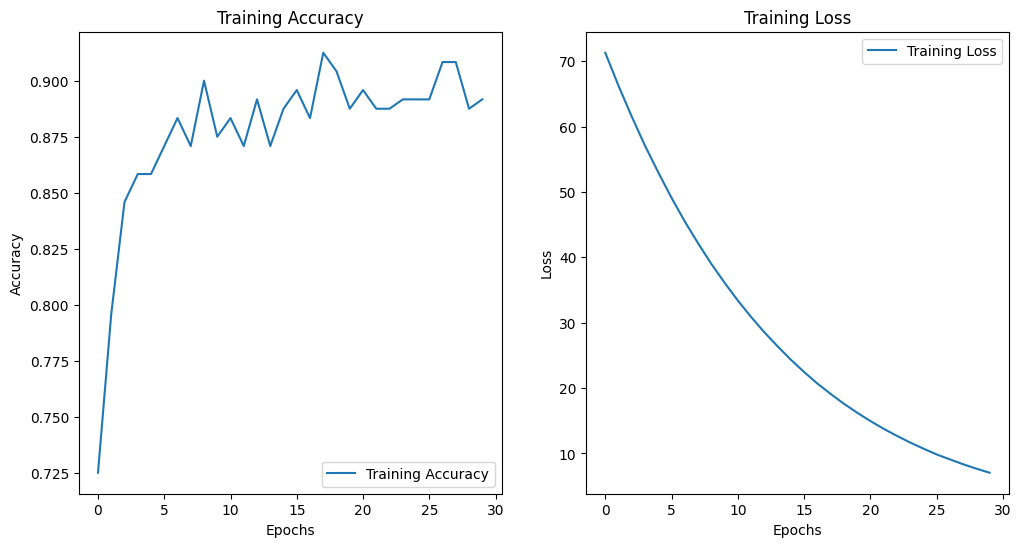

In [9]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    acc = history.history['accuracy']
    loss = history.history['loss']
    epochs_range = range(len(acc))
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training Accuracy')
    plt.legend(loc='lower right')
    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training Loss')
    plt.legend(loc='upper right')
    plt.show()
plot_training_history(history)

In [10]:
import shutil

shutil.make_archive('model', 'zip', 'model')

from google.colab import files
files.download('model.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

FileUpload(value={}, accept='image/*', description='Upload')

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
[0.49081895]


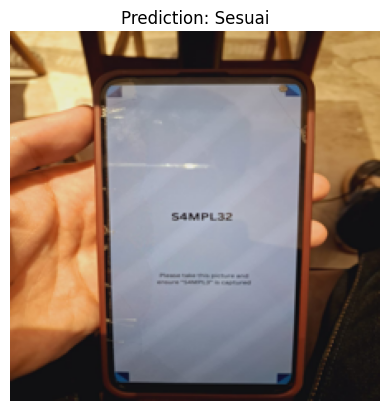

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.43341202]


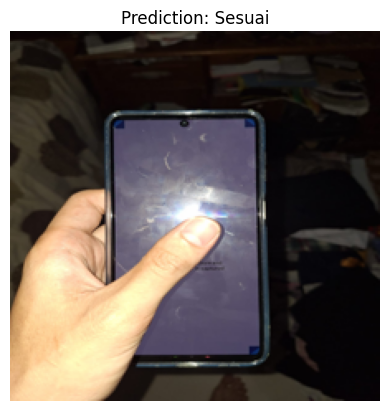

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
[0.13651745]


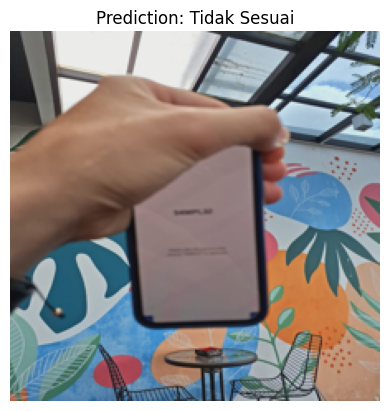

Prediction result: Tidak Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.25501984]


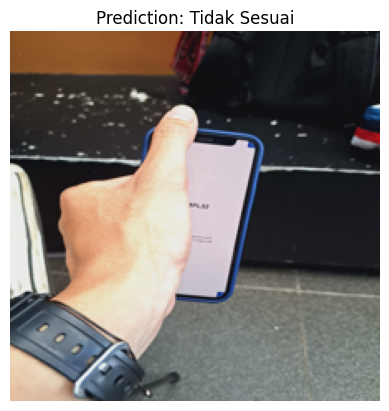

Prediction result: Tidak Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.25660685]


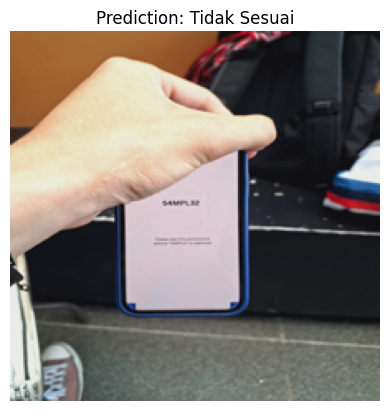

Prediction result: Tidak Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.44673556]


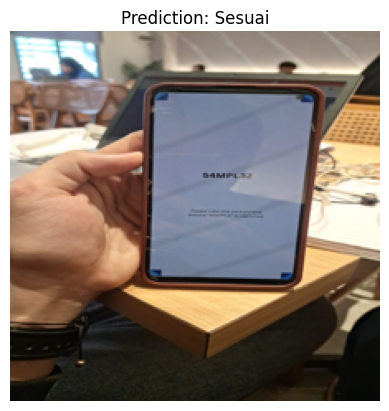

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.4353474]


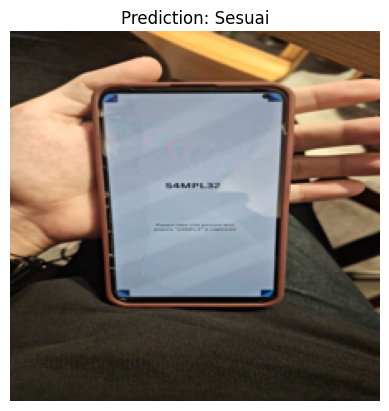

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[0.417439]


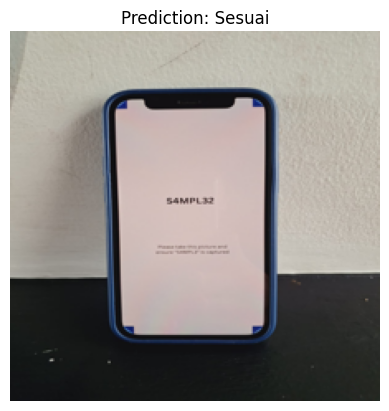

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0.41257423]


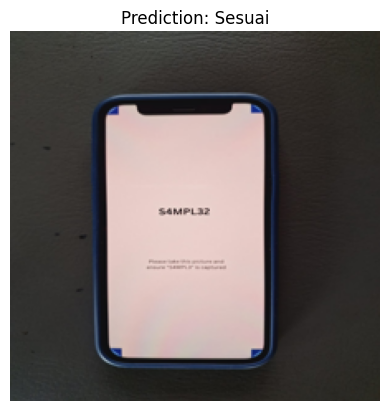

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
[0.40000984]


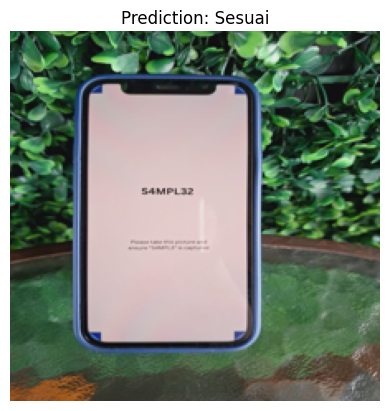

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
[0.41299137]


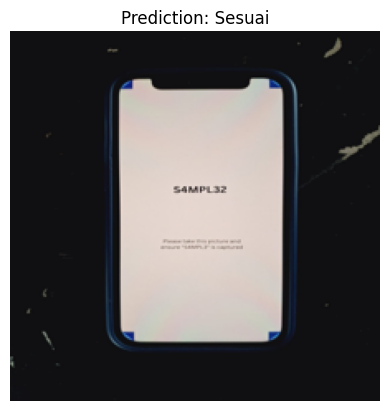

Prediction result: Sesuai
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step
[0.31364113]


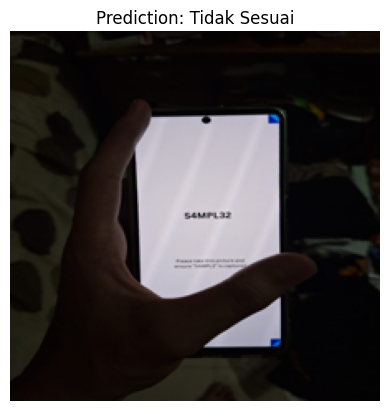

Prediction result: Tidak Sesuai


In [11]:
from PIL import Image
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from io import BytesIO
import IPython.display as display
import ipywidgets as widgets
from IPython.display import display

# Create an upload button widget
upload_button = widgets.FileUpload(accept='image/*', multiple=False)
display(upload_button)

# Function to preprocess and predict
def predict_uploaded_image(model, uploaded_file):
    # Read and preprocess the image
    img = Image.open(BytesIO(uploaded_file['content']))
    img = img.resize((224, 224))  # Resize to the input shape used in training
    img_array = np.array(img) / 255.0  # Normalize to [0, 1]
    img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

    # Run prediction
    prediction = model.predict(img_array)

    # Interpret the result
    if prediction[0] > 0.40:
        result = "Sesuai"  # Prediction is class 1
        print(prediction[0])
    else:
        result = "Tidak Sesuai"  # Prediction is class 0
        print(prediction[0])

    # Display the image and result
    plt.imshow(img)
    plt.title(f"Prediction: {result}")
    plt.axis('off')
    plt.show()

    print(f"Prediction result: {result}")
    return result

# Callback function to handle the uploaded file
def on_upload_change(change):
    # Get the uploaded image file content
    uploaded_file = list(upload_button.value.values())[0]
    # Call the prediction function with the uploaded image
    predict_uploaded_image(model, uploaded_file)

# Bind the callback function to the upload button
upload_button.observe(on_upload_change, names='value')


In [12]:
# convert to tflite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.experimental_new_converter = True

# Add NormalizationOptions metadata
def representative_dataset_gen():
    for _ in range(100):
        yield [np.random.rand(1, 224, 224, 3).astype(np.float32)]

converter.representative_dataset = representative_dataset_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.inference_input_type = tf.uint8  # or tf.int8
converter.inference_output_type = tf.uint8  # or tf.int8

tflite_model = converter.convert()

# Save the quantized model to a file
with open('model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpnmkmun0n'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_159')
Output Type:
  TensorSpec(shape=(None, 1), dtype=tf.float32, name=None)
Captures:
  132455517652944: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132455305937488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132455305941008: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132458226923856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132455517918784: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132455305943824: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132455306158928: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132455306159984: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132455306156112: TensorSpec(shape=(), dtype=tf.resource, name=None)
  132455306158752: TensorSpec(shape=(), dtype=tf.resource, name=None)
  1324553061

/usr/local/lib/python3.10/dist-packages/tensorflow/lite/python/convert.py:983: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(


In [ ]:
pip install tflite-support-nightly

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 MB 10.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 46.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 243.3/243.3 kB 16.2 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requires protobuf>=4.21.6, but you have protobuf 3.20.3 which is incompatible.


In [ ]:
import tensorflow as tf

# Load the TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()

# Get input and output details.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

RuntimeError: failed to create XNNPACK runtimeNode number 124 (TfLiteXNNPackDelegate) failed to prepare.

In [ ]:
!pip install --upgrade tensorflow # Upgrade to ensure access to newer functionality

interpreter = tf.lite.Interpreter(model_path="model.tflite", experimental_delegates=None)
# Disable XNNPACK delegate explicitly
interpreter.options.use_xnnpack = False
interpreter.allocate_tensors()
# Get input and output details
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Test with sample input
import numpy as np
sample_input = np.random.rand(1, 224, 224, 3).astype(np.float32)
interpreter.set_tensor(input_details[0]['index'], sample_input)
interpreter.invoke()

# Get predictions
output_data = interpreter.get_tensor(output_details[0]['index'])
print("Model Output:", output_data)

RuntimeError: failed to create XNNPACK runtimeNode number 124 (TfLiteXNNPackDelegate) failed to prepare.

In [ ]:
# Load the model
interpreter = tf.lite.Interpreter(model_path="model.tflite")
interpreter.allocate_tensors()
interpreter.options.use_xnnpack = False
# Get input details
input_details = interpreter.get_input_details()
print(input_details)